In [1]:
import os, sys, json, shapely
os.environ['USE_PYGEOS'] = '0'
from datetime import date, datetime
import pandas as pd; import numpy as np; import geopandas as gpd

In [2]:
DATE = '2024-10-20'

In [3]:
df = pd.read_parquet(f"ym_{DATE}.parquet")
df = df.rename(columns={'_day':'day'})
df['highways']      = df['new_highways']  + df['edited_highways']
df['buildings']     = df['new_buildings'] + df['edited_buildings']
df['amenities']     = df['new_amenities'] + df['edited_amenities']
df['all_feats']     = df['new_features']  + df['edited_features']
print(f"Read {len(df):,} rows, latest ds: ", df.day.max())
print(f"Null Geometries: {len(df[pd.isnull(df.centroid)])}")
df.head(2)

Read 677,146 rows, latest ds:  2024-10-13
Null Geometries: 0


,day,quadkey,centroid,convex_hull,new_highways,new_buildings,new_amenities,edited_highways,edited_buildings,edited_amenities,...,city,country,chapter_lon,chapter_lat,km_to_university,ds,highways,buildings,amenities,all_feats
0,2024-08-24,132022013030120,b'\x01\x01\x00\x00\x00\xd1+\x9ezL\x15W@\xe3\xb...,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x...",0,158,0,2,1,0,...,Arusha,Tanzania,36.711538,-3.413995,6823.695934,2024-10-20,2,159,0,161
1,2024-08-24,132022230202322,b'\x01\x01\x00\x00\x00\x8b\xc7\xa0n{\xddV@\x87...,b'\x01\x01\x00\x00\x00\x8b\xc7\xa0n{\xddV@\x87...,0,9,0,0,0,0,...,Arusha,Tanzania,36.711538,-3.413995,6611.138087,2024-10-20,0,9,0,9


In [4]:
# Drop NULL centroid geometries
df = pd.DataFrame(df[pd.notnull(df.centroid)])

# Create geometry objects
df['geometry'] = df.centroid.apply(shapely.wkb.loads)
df['convex_hull_geom'] = df.convex_hull.apply(shapely.wkb.loads)

In [5]:
def array_to_hist(arr):
    m = dict()
    for x in arr:
        if x in m:
            m[x] += 1
        else:
            m[x] = 1
    return m

In [6]:
#Create hashtag sets and make it a GeoDataFrame:
df['hashtags_hist'] = df.hashtags.apply(array_to_hist)

# Now make a GeoDataFrame
df = gpd.GeoDataFrame(df)

In [7]:
print(f"Mappers Count: {df.uid.nunique()}, Chapter count: {df.chapter.nunique()}")

Mappers Count: 3253, Chapter count: 239


### Write JSONP Files for Chapter Index: `data/chapters_and_uids.jsonp`

In [8]:
chapters = df.drop_duplicates(subset=['chapter_id'])[['chapter','chapter_id','city','country','university']]
chapters['Chapter Name'] = chapters.chapter

with open('chapters_and_uids.jsonp','w') as outFile:
    outFile.write( 'var chapters = ' + json.dumps(
        chapters.sort_values(by='chapter').to_dict(orient='records'))+"\n")
    
chapters.head(1)

,chapter,chapter_id,city,country,university,Chapter Name
0,IAA YouthMappers,71,Arusha,Tanzania,Institute of Accountancy Arusha,IAA YouthMappers


In [9]:
sys.stderr.write("Quantifying All Hashtags...")
TAG_COUNTS = {}
for x in df.hashtags_hist:
    for y in x:
        if y in TAG_COUNTS:
            TAG_COUNTS[y]+=x[y]
        else:
            TAG_COUNTS[y]=x[y]
tag_counts_df = pd.DataFrame.from_dict(TAG_COUNTS,orient='index', 
  columns=['count']).sort_values(by='count', ascending=False).reset_index().rename(columns={'index':'hashtag'})
sys.stderr.write("Done.\n")
display(tag_counts_df.head())

Quantifying All Hashtags...Done.


,hashtag,count
0,#YouthMappers,80553
1,#youthmappers,70107
2,#missingmaps,59627
3,#maproulette,49652
4,#MissingMaps,38807


# Export Files for Graphs: `monthly_activity_*.json`

In [10]:
df['month'] = df.day.apply(lambda d: date(d.year, d.month,15))

In [11]:
_aggregations = {'new_buildings':'sum','new_highways':'sum','new_amenities':'sum', 
     'edited_buildings':'sum', 'edited_highways':'sum', 'edited_amenities':'sum',
     'uid':'nunique','chapter':'nunique'}

today      = datetime.now();
this_month = date(today.year, today.month, 1)

# All time:
monthly_activity_all_time = df[df.month < this_month].groupby('month').aggregate(_aggregations).rename(
columns={'uid':'users','chapter':'chapters'})

monthly_activity_all_time.reset_index(inplace=True)

# Write out all activity over time
monthly_activity_all_time.to_json('monthly_activity_all_time.json',orient='records')

# Write out just last 1200 days activity
monthly_activity_all_time[monthly_activity_all_time.month > (this_month - 
                                 pd.Timedelta(days=1200))].to_json('monthly_activity_last_1200_days.json',orient='records')
# Write out just last year's activity
monthly_activity_all_time[monthly_activity_all_time.month > (this_month - 
                                 pd.Timedelta(days=365))].to_json('monthly_activity_last_year.json',orient='records')


<Axes: >

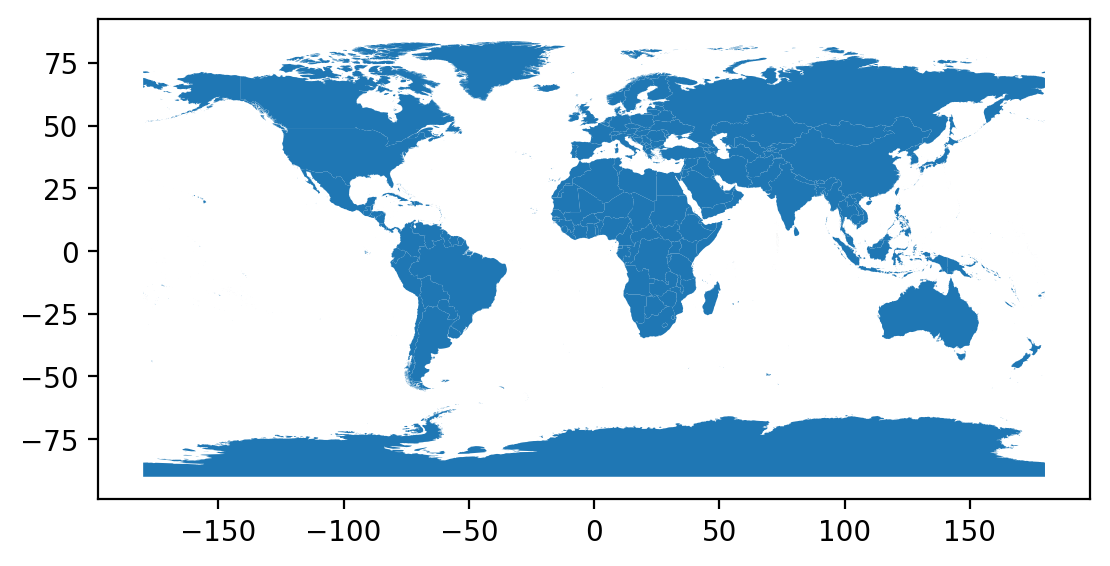

In [12]:
# Import country boundaries
countries = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')[
    ['NAME','ADM0_A3','CONTINENT','SUBREGION','geometry']
].rename(columns={'NAME':"edit_country","ADM0_A3":'edit_A3',"CONTINENT":'edit_continent','SUBREGION':'edit_subregion'})

countries.plot()

In [13]:
df_ = df.set_crs('EPSG:4326').sjoin(countries)
df_.head()

,day,quadkey,centroid,convex_hull,new_highways,new_buildings,new_amenities,edited_highways,edited_buildings,edited_amenities,...,all_feats,geometry,convex_hull_geom,hashtags_hist,month,index_right,edit_country,edit_A3,edit_continent,edit_subregion
0,2024-08-24,132022013030120,b'\x01\x01\x00\x00\x00\xd1+\x9ezL\x15W@\xe3\xb...,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x...",0,158,0,2,1,0,...,161,POINT (92.33279 26.24857),"POLYGON ((92.330872 26.2447274, 92.333086 26.2...","{'#hotosm-project-15229': 16, '#OSMIndia': 16,...",2024-08-15,8,India,IND,Asia,Southern Asia
2,2024-08-24,132020323321023,b'\x01\x01\x00\x00\x00\xe6\xf9\x1d\xd4\x0f~W@\...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,0,13,0,0,0,0,...,13,POINT (93.96972 27.18041),"POLYGON ((93.968754 27.1793487, 93.969485 27.1...","{'#hotosm-project-15127': 4, '#OSMIndia': 4, '...",2024-08-15,8,India,IND,Asia,Southern Asia
3,2024-08-24,132022011232322,b'\x01\x01\x00\x00\x00\x9f\xf5:\xf3<\x15W@\xf6...,b'\x01\x01\x00\x00\x00\x9f\xf5:\xf3<\x15W@\xf6...,0,52,0,0,20,0,...,72,POINT (92.33185 26.43780),POINT (92.3318451 26.4377967),"{'#hotosm-project-15229': 1, '#OSMIndia': 1, '...",2024-08-15,8,India,IND,Asia,Southern Asia
4,2024-08-24,132022013010101,b'\x01\x01\x00\x00\x00z\xc9Z\x9e\xe2\x15W@\x0c...,b'\x01\x01\x00\x00\x00z\xc9Z\x9e\xe2\x15W@\x0c...,0,27,0,0,11,0,...,38,POINT (92.34196 26.42879),POINT (92.3419567 26.4287906),"{'#hotosm-project-15229': 1, '#OSMIndia': 1, '...",2024-08-15,8,India,IND,Asia,Southern Asia
5,2024-08-24,132022013002130,b'\x01\x01\x00\x00\x00N\x8em\xdf\xc4\x0bW@*\xb...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x04\x00...,0,74,0,2,22,0,...,98,POINT (92.18389 26.32778),"POLYGON ((92.1845518 26.3234453, 92.1852779 26...","{'#hotosm-project-15229': 5, '#OSMIndia': 5, '...",2024-08-15,8,India,IND,Asia,Southern Asia


# Export Top Edited Countries: `top_edited_countries.json`

In [14]:
top_edited_countries = []

for month, rows in df_[df_.month > this_month - pd.Timedelta(days=90)].groupby('month'):
    t15 = rows.groupby('edit_country').aggregate({'all_feats':'sum'}).sort_values(by='all_feats',ascending=False).head(15)
    
    top_edited_countries.append({'month': month.isoformat(), 'top_countries': list(zip(list(t15.index), list(t15.all_feats)))})
    
json.dump(top_edited_countries, open('top_edited_countries.json','w'))
          

In [15]:
# Which chapters are active in the most edited countries?
top_country = top_edited_countries[-1].get('top_countries')[0][0]
df_[df_.edit_country==top_country].groupby('chapter').aggregate(
    {'uid':'nunique','all_feats':'sum'}
        ).sort_values(by='all_feats', ascending=False).head()

,uid,all_feats
chapter,,
YouthMappers at Texas Tech University,14,267608
Meta_GWU,15,203224
YouthMappers ASU,20,37988
YouthMappers Steering Committee,13,27963
UCC YouthMappers,45,18712


### Local Editing?

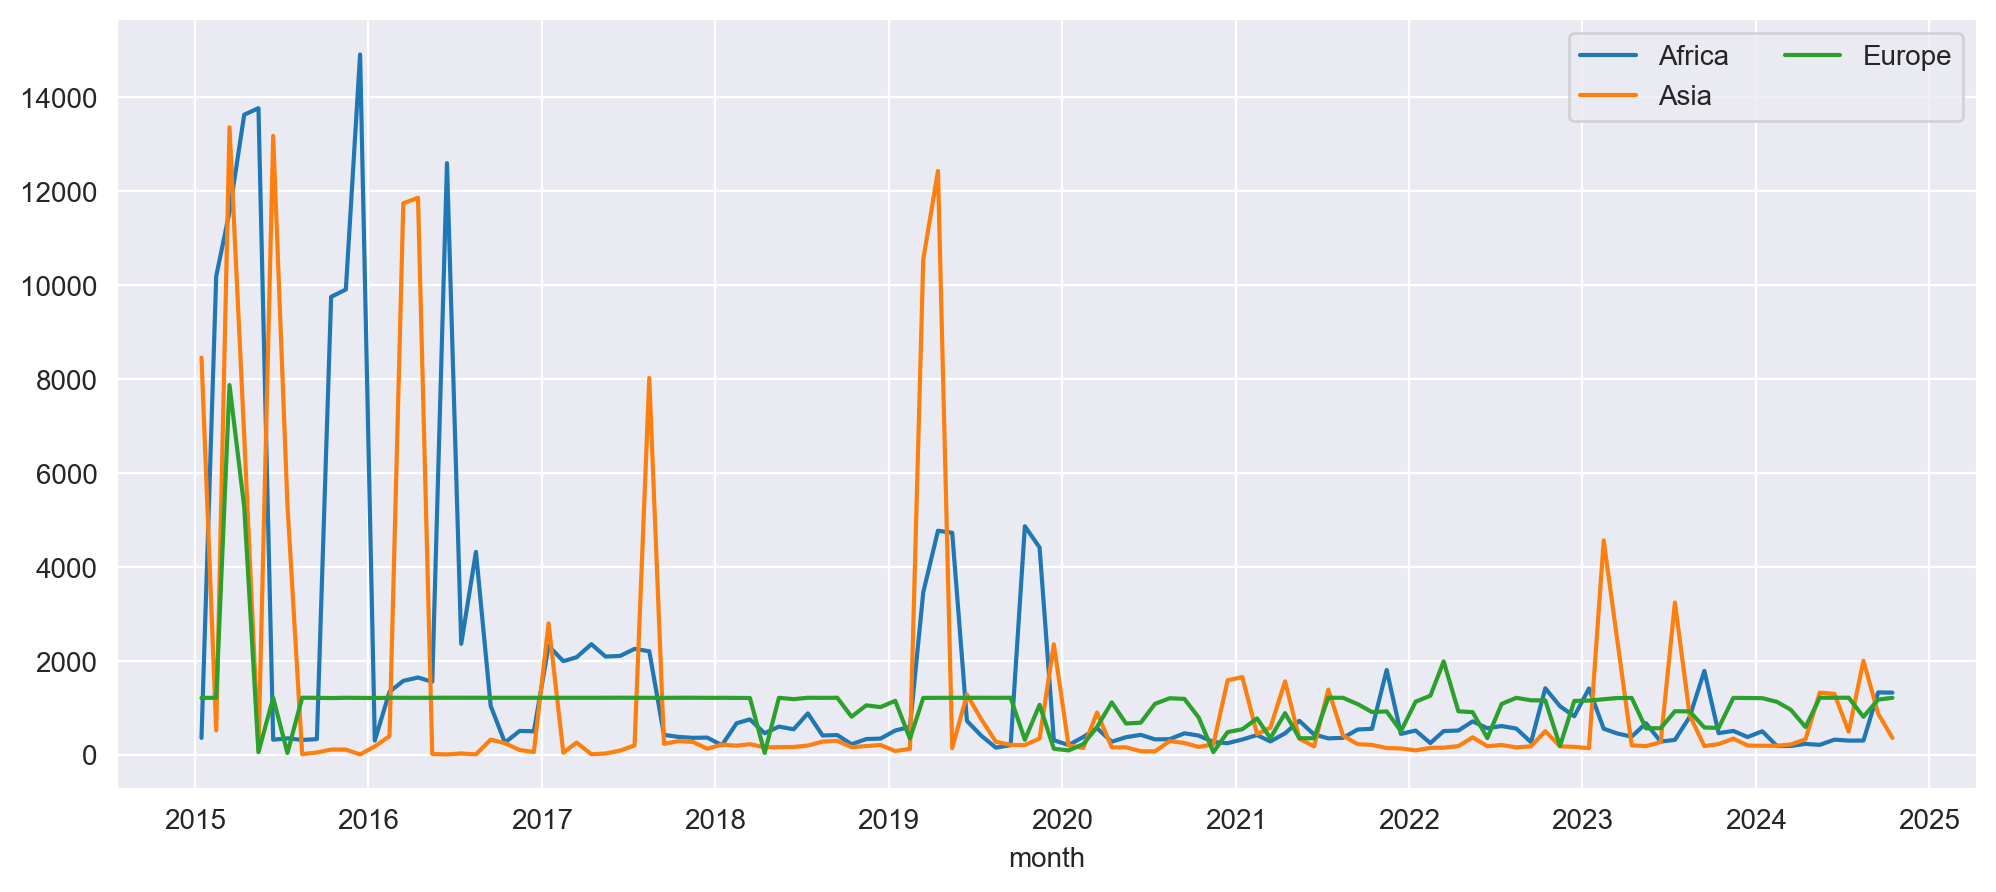

In [16]:
import seaborn as sns
sns.set_style("darkgrid")
ax = df_.groupby(['month','edit_continent']).aggregate(
    {'km_to_university':'median'}
).unstack().km_to_university[
    ['Africa','Asia','Europe']].plot(figsize=(12,5))
ax.legend(loc='best',ncol=2)
ax.set_ylabel("Median distance (km) from home\nUniversity that YouthMappers are editing.", fontsize=16)
ax.set_ylabel(None);

<br>
<br>
<hr>

# MEL Reporting Requirements

In [17]:
df_['month'] = df_.day.apply(lambda d: date(d.year, d.month, 15))
df.head(2)

,day,quadkey,centroid,convex_hull,new_highways,new_buildings,new_amenities,edited_highways,edited_buildings,edited_amenities,...,chapter_lat,km_to_university,highways,buildings,amenities,all_feats,geometry,convex_hull_geom,hashtags_hist,month
0,2024-08-24,132022013030120,b'\x01\x01\x00\x00\x00\xd1+\x9ezL\x15W@\xe3\xb...,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x...",0,158,0,2,1,0,...,-3.413995,6823.695934,2,159,0,161,POINT (92.33279 26.24857),"POLYGON ((92.330872 26.2447274, 92.333086 26.2...","{'#hotosm-project-15229': 16, '#OSMIndia': 16,...",2024-08-15
1,2024-08-24,132022230202322,b'\x01\x01\x00\x00\x00\x8b\xc7\xa0n{\xddV@\x87...,b'\x01\x01\x00\x00\x00\x8b\xc7\xa0n{\xddV@\x87...,0,9,0,0,0,0,...,-3.413995,6611.138087,0,9,0,9,POINT (91.46066 22.76479),POINT (91.4606587 22.7647886),"{'#hotosm-project-17447': 1, '#OSMBDECTeam': 1...",2024-08-15


In [18]:
df_.gender = df_.gender.fillna('').apply(lambda s: s.lower())

<Axes: xlabel='month'>

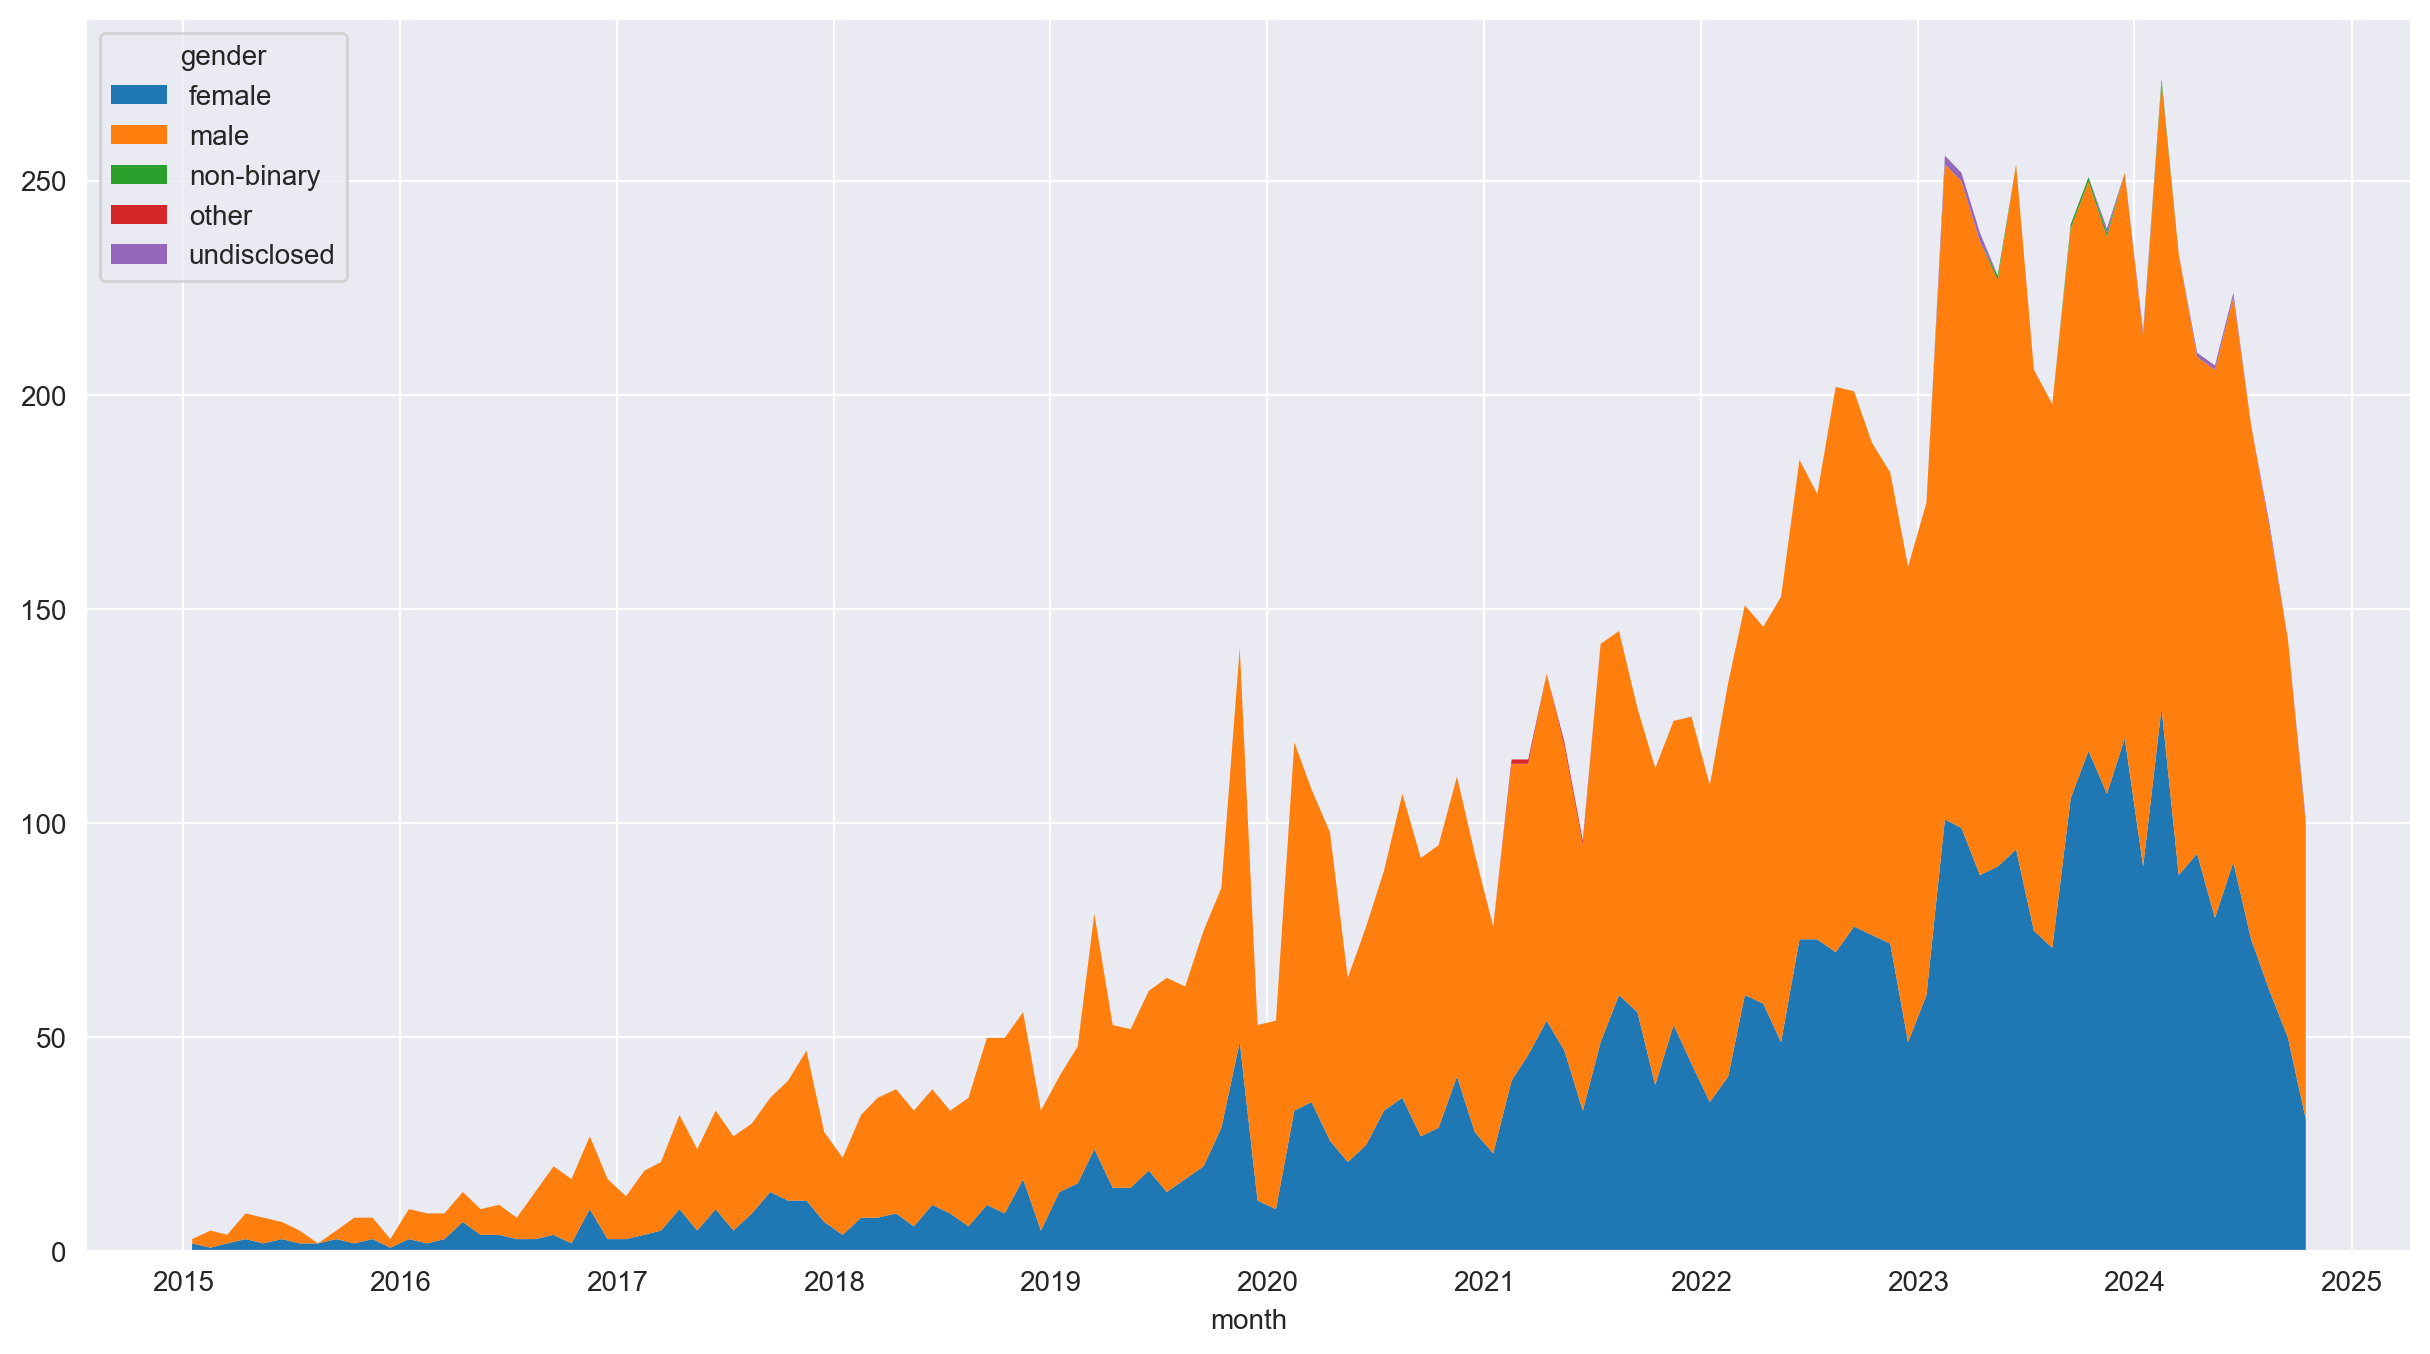

In [19]:
gb_month_gender = df_[df_.gender != ''].groupby(['month','gender']).aggregate({
    'uid':'nunique', 
    'chapter_id':'nunique',
    'highways':"sum", 
    'buildings':"sum",
    'amenities':"sum", 
    'all_feats':"sum" 
})

gb_month_gender.unstack().uid.plot.area(stacked=True, lw=0, figsize=(15,8))
                                           

In [20]:
gb_month_gender.rename(columns={'uid':'mappers','chapter_id':'chapters'}).to_csv('mappers_per_month_with_gender.csv')

In [21]:
print( df_.groupby(['gender']).aggregate({
    'uid':'nunique', 
    'chapter_id':'nunique',
    'highways':"sum", 
    'buildings':"sum",
    'amenities':"sum", 
    'all_feats':"sum" 
}).rename(columns={'uid':'mappers','chapter_id':'chapters'}).to_csv())

gender,mappers,chapters,highways,buildings,amenities,all_feats
,1824,184,1117579,13784837,174953,16190445
female,600,128,168423,3125306,14049,3565580
male,819,159,700713,9681952,102041,11141234
non-binary,2,2,9,409,0,424
other,1,1,11,0,4,61
undisclosed,2,2,265,2327,1623,4397



<br><br>
<hr>
<br><br>

# Summary Stats and Visualizations

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [23]:
print("Overall, our dataset contains {:,} known YouthMapper usernames from {:,} chapters that have made at least 1 edit in OSM".format(
    df.uid.nunique(), df.chapter.nunique())
)

Overall, our dataset contains 3,253 known YouthMapper usernames from 239 chapters that have made at least 1 edit in OSM


## Time Bounded

In [24]:
START_DATE  = date(2024,1,1)
END_DATE    = date(2024,8,18)

In [25]:
_slice = df[ (df.day >= START_DATE) & 
             (df.day  < END_DATE) ]
print("In this time slice, we saw:\n\t{:,} Distinct YouthMappers from \n\t{:,} Chapters".format(
    _slice.uid.nunique(),_slice.chapter.nunique()))
first_edits = df.groupby('uid').aggregate({'day':'min'}).reset_index()
print("\t{} of these mappers made their first edit.".format(len(
    first_edits[(first_edits.day >= START_DATE) & (first_edits.day < END_DATE)])))

In this time slice, we saw:
	860 Distinct YouthMappers from 
	156 Chapters
	157 of these mappers made their first edit.


In [26]:
print("New Objects:\n\tBuildings: {:,}\n\tHighways:  {:,}\n\tAmenities: {:,}\n\tOther:     {:,}".format(
    _slice.new_buildings.sum(), _slice.new_highways.sum(), _slice.new_amenities.sum(),
    _slice.new_features.sum() - (_slice.new_buildings.sum()+_slice.new_highways.sum()+_slice.new_amenities.sum())))
print("===========================")
print("Edited Objects:\n\tBuildings: {:,}\n\tHighways:  {:,}\n\tAmenities: {:,}\n\tOther:     {:,}".format(
    _slice.edited_buildings.sum(), _slice.edited_highways.sum(), _slice.edited_amenities.sum(),
    _slice.edited_features.sum() - (_slice.edited_buildings.sum()+_slice.edited_highways.sum()+_slice.edited_amenities.sum())))

New Objects:
	Buildings: 2,951,307
	Highways:  131,836
	Amenities: 19,106
	Other:     101,660
Edited Objects:
	Buildings: 363,845
	Highways:  201,483
	Amenities: 9,718
	Other:     75,496


## Top Chapters

In [27]:
top_chaps = _slice.groupby('chapter').aggregate(
    {'uid':'nunique',
     'new_features': 'sum',
     'edited_features': 'sum',
     'sum_edits': 'sum',
     'all_feats': 'sum',
     'highways': 'sum',
     'buildings': 'sum',
     'amenities': 'sum'}).sort_values(by='all_feats', ascending=False).rename(
    columns={'uid':"Mappers"})
top_chaps.head()

,Mappers,new_features,edited_features,sum_edits,all_feats,highways,buildings,amenities
chapter,,,,,,,,
YouthMappers FUTA,25,999831,244745,7263822,1244576,39466,1180104,383
Youthmappers OAU,7,295452,49027,2272763,344479,26090,316926,483
UDOM YOUTHMAPPERS,30,249125,11298,1511606,260423,14109,244500,151
Meta_GWU,15,72977,97177,271889,170154,124218,2896,25
Good Mappers,6,106327,2211,675462,108538,1777,106499,43


## Per Continent Stats

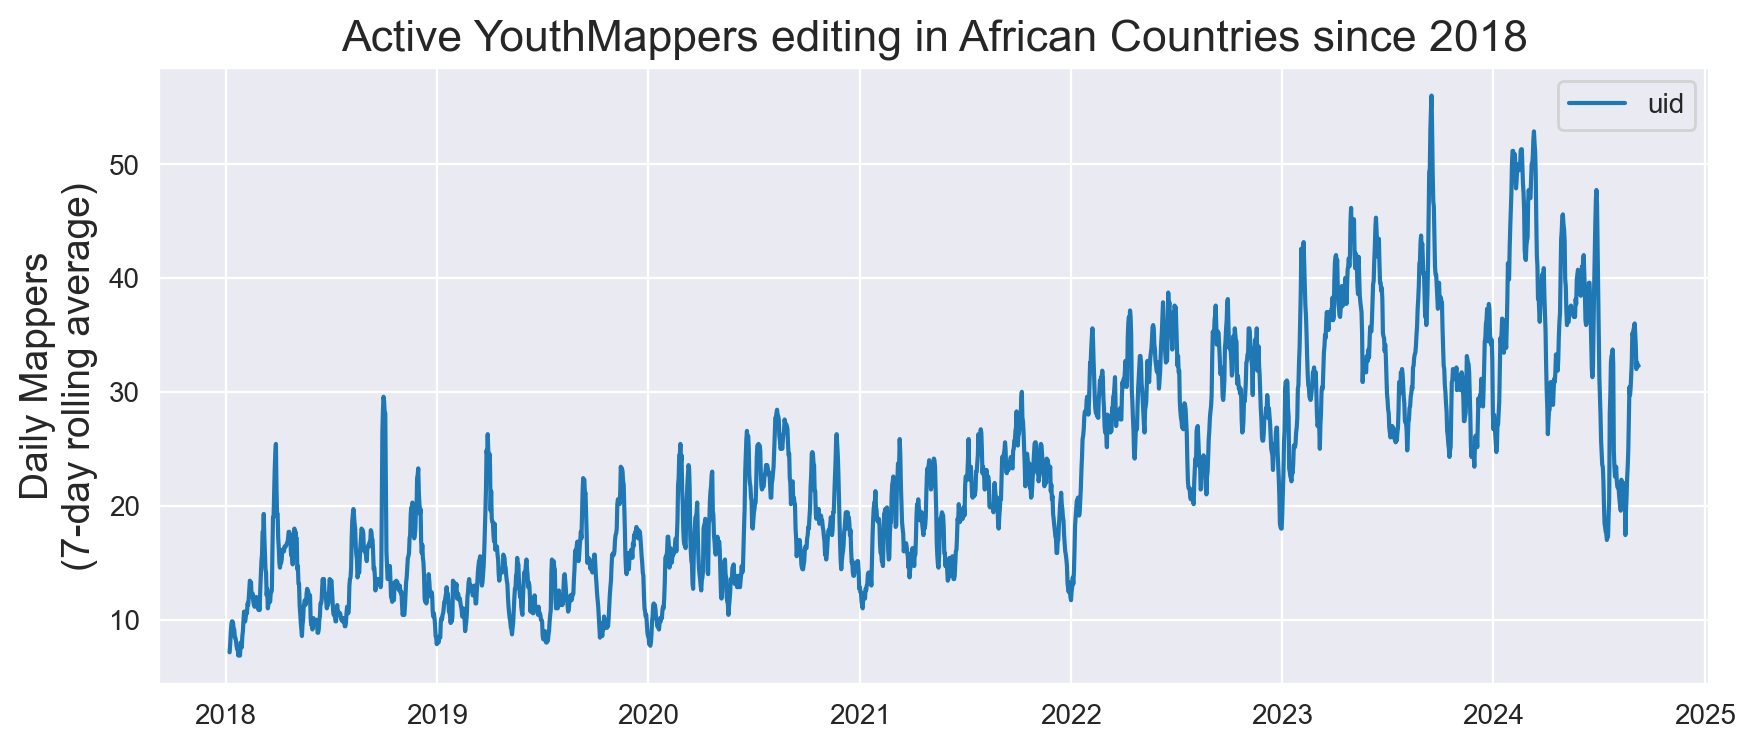

In [28]:
ax = df_[(df_.edit_continent=='Africa') & 
         (df_.day>date(2018,1,1))
        ].groupby('day').aggregate({'uid':'nunique'}).sort_index().rolling(7).mean().plot(figsize=(10,4))
ax.set_title("Active YouthMappers editing in African Countries since 2018", fontsize=16)
ax.set_ylabel("Daily Mappers\n(7-day rolling average)", fontsize=14); ax.set_xlabel(None);

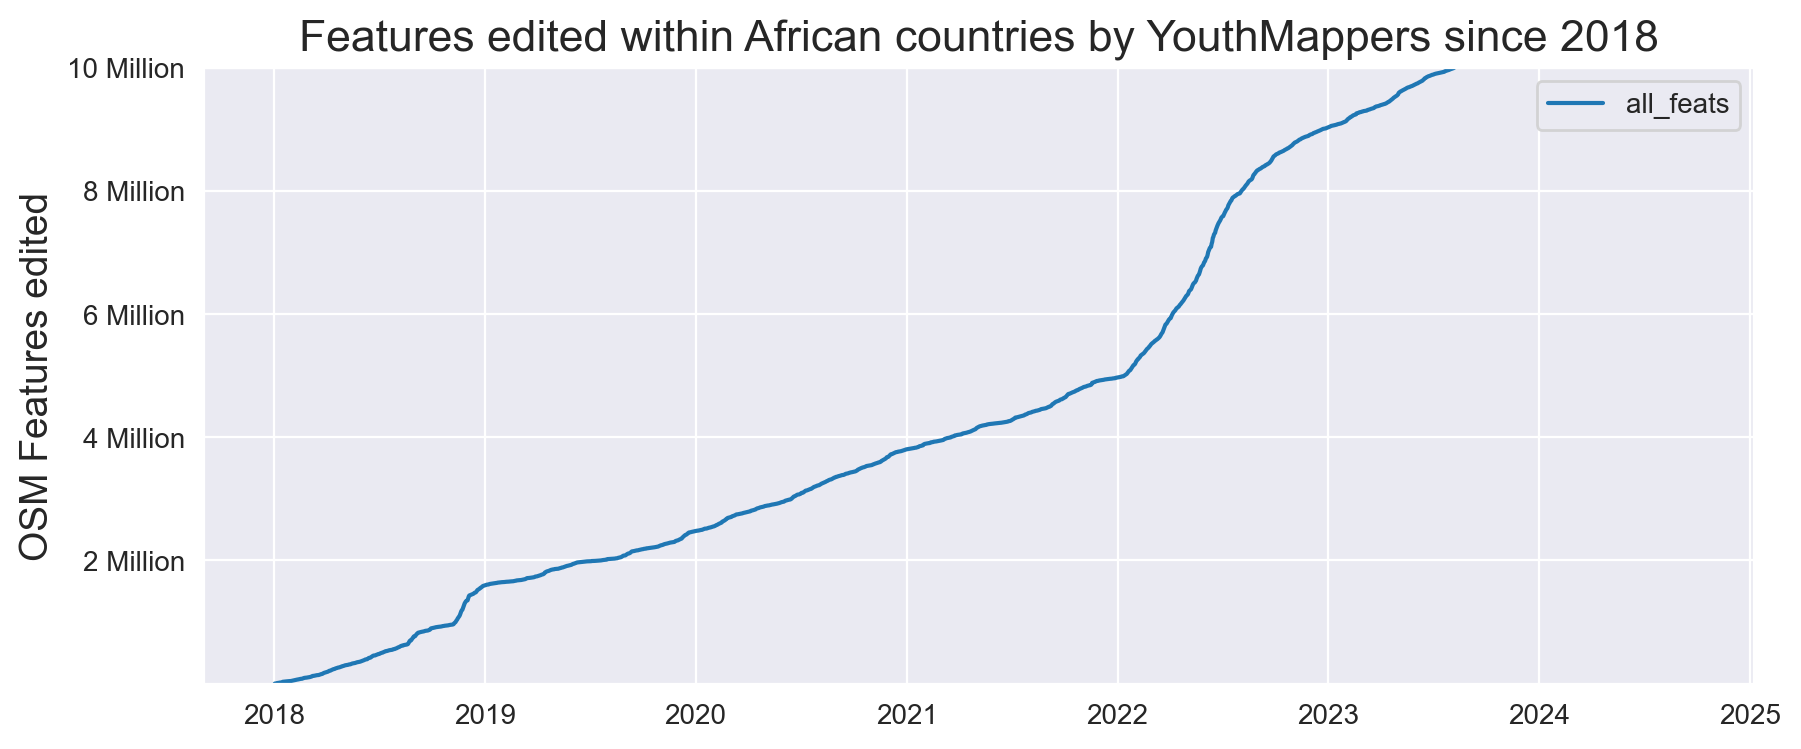

In [29]:
ax = df_[(df_.edit_continent=='Africa') & 
         (df_.day>date(2018,1,1))
        ].groupby('day').aggregate({'all_feats':'sum'}).sort_index().cumsum().plot(figsize=(10,4))
ax.set_title("Features edited within African countries by YouthMappers since 2018", fontsize=16)
ax.set_ylabel("OSM Features edited", fontsize=14); ax.set_xlabel(None);
ax.yaxis.set_major_formatter(lambda x, pos: "{} Million".format(int(x/1000000)))
ax.set_ylim(1,10000000);

In [30]:
print("Top 15 Countries by New Features Count")
aggregators = {'new_features':'sum','new_buildings':'sum', 'new_highways':'sum', 'new_amenities':'sum', 
        'edited_features':'sum', 'chapter':'nunique', 'uid':'nunique'}
_slice.groupby('country').aggregate(aggregators
    ).sort_values(by='new_features',ascending=False).head(15).rename(columns={'chapter':"# Chapters",'uid':"# Mappers"})


Top 15 Countries by New Features Count


,new_features,new_buildings,new_highways,new_amenities,edited_features,# Chapters,# Mappers
country,,,,,,,
Nigeria,1358803,1319705,20477,449,312457,10,51
Tanzania,497899,483486,11059,94,26527,13,112
Bangladesh,322711,295934,7139,7346,16808,13,63
Uganda,147819,146465,1179,51,3303,7,23
Nepal,141386,131576,3366,1951,34203,5,32
,105186,32137,56086,131,98932,6,39
Sri Lanka,98156,83478,4611,3117,12209,3,76
Ghana,85231,77689,2380,216,19789,8,117
Kenya,83923,76508,5190,28,16404,6,65


Text(0.5, 1.0, 'Edit Concentration')

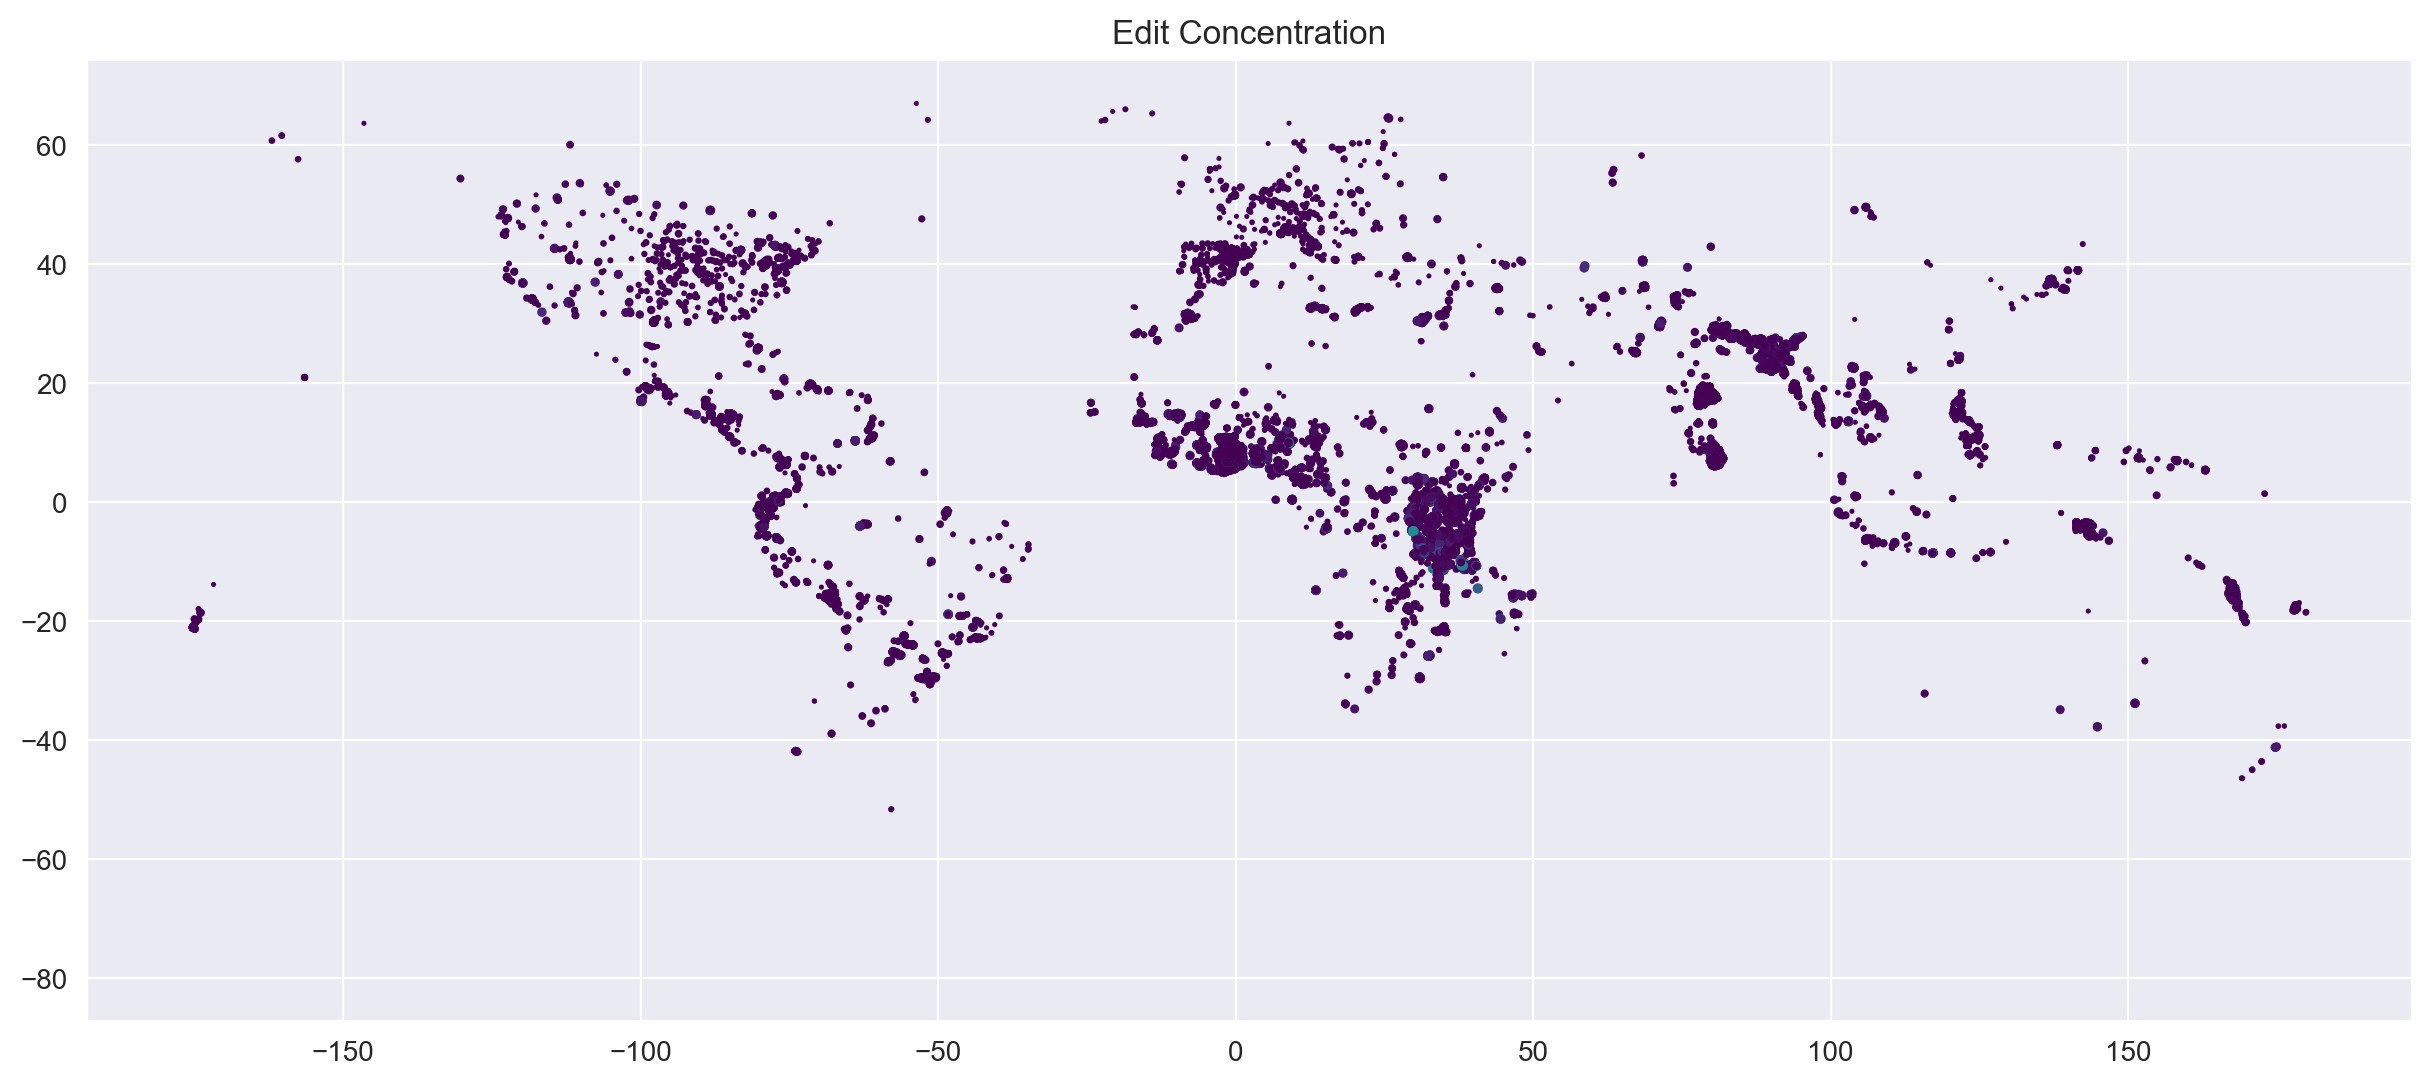

In [31]:
ax = _slice.plot(column='new_features',cmap='viridis', figsize=(15,8), s=np.log1p(_slice.all_feats))
ax.set_title("Edit Concentration")

In [32]:
df['month'] = df.day.apply(lambda d: date(d.year, d.month, 15))
gb_month = df.groupby('month').aggregate(aggregators)

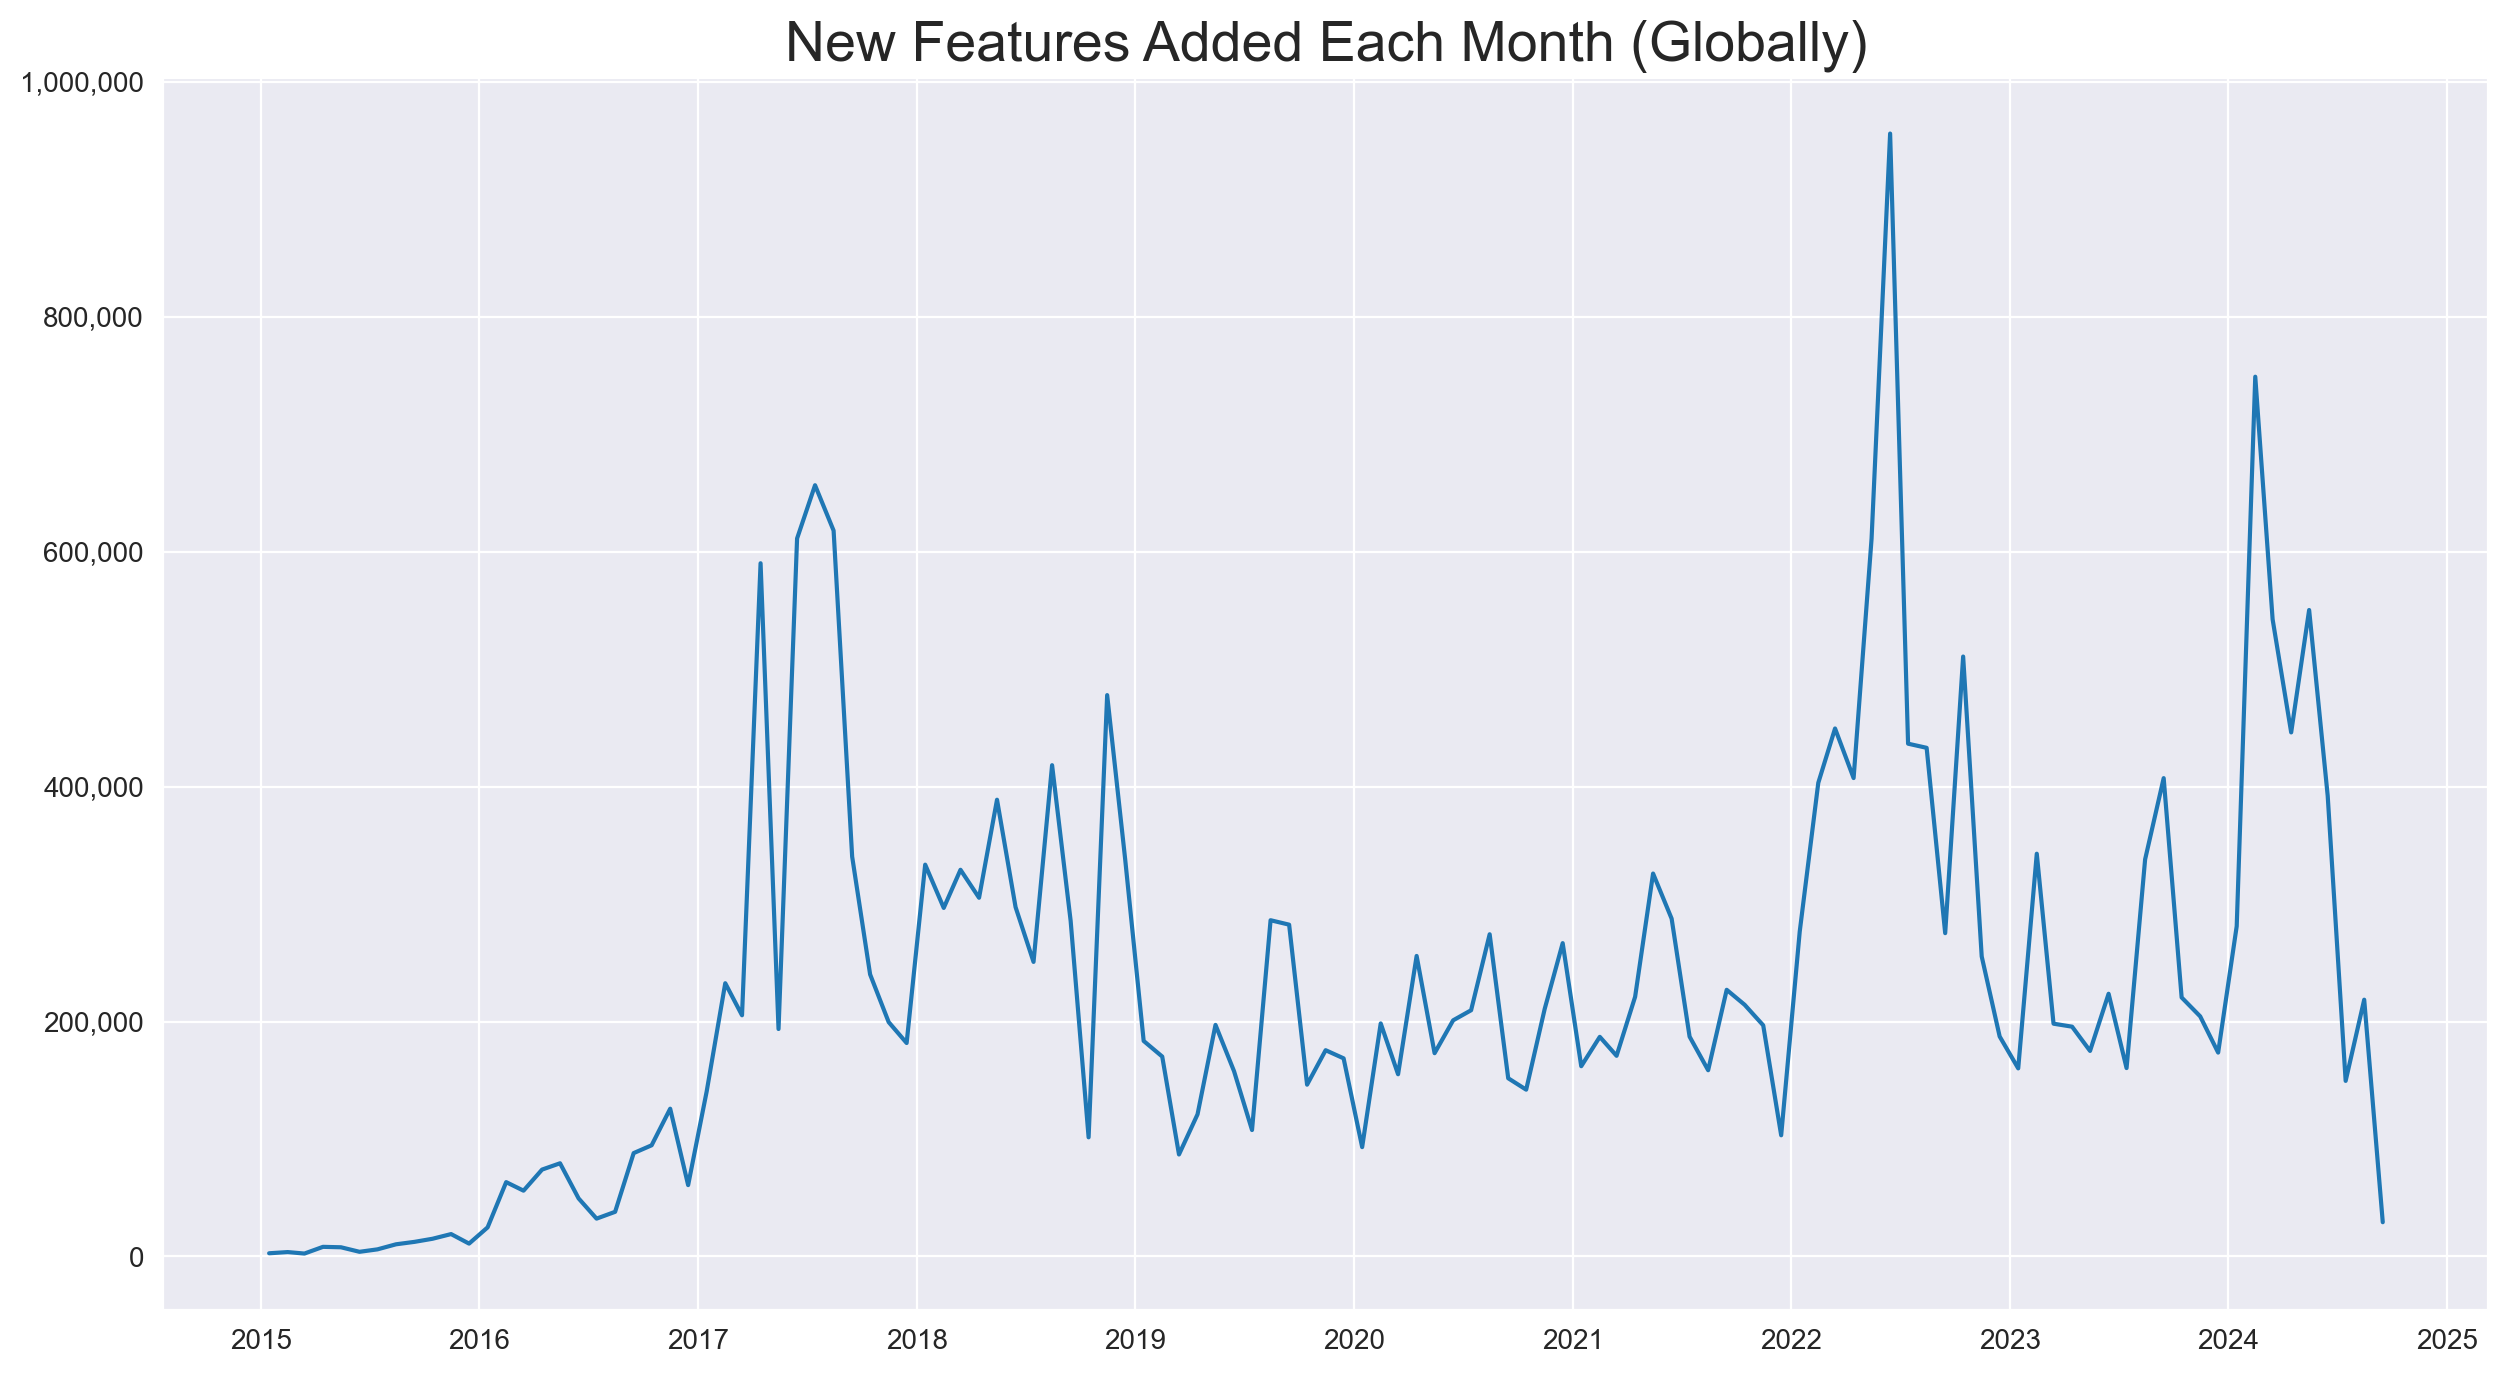

In [33]:
sns.set_style('darkgrid')
ax = gb_month['new_features'].plot(figsize=(15,8))
ax.set_title("New Features Added Each Month (Globally)", fontsize=20)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(lambda x, pos: "{:,}".format(int(x)))

In [34]:
days_per_mapper = df.groupby('uid').aggregate({'day':'nunique'}).reset_index()
active_contributors = days_per_mapper[days_per_mapper.day>=42].uid

print("There are {} _active contributors_ in YouthMappers (mapped for at least 42 days)".format(len(active_contributors)))
print("{} of these mappers were active in this time slice".format(_slice[_slice.uid.isin(active_contributors)].uid.nunique()))

There are 539 _active contributors_ in YouthMappers (mapped for at least 42 days)
319 of these mappers were active in this time slice


Text(0.5, 1.0, 'Number of Distinct Chapters Active Each Month')

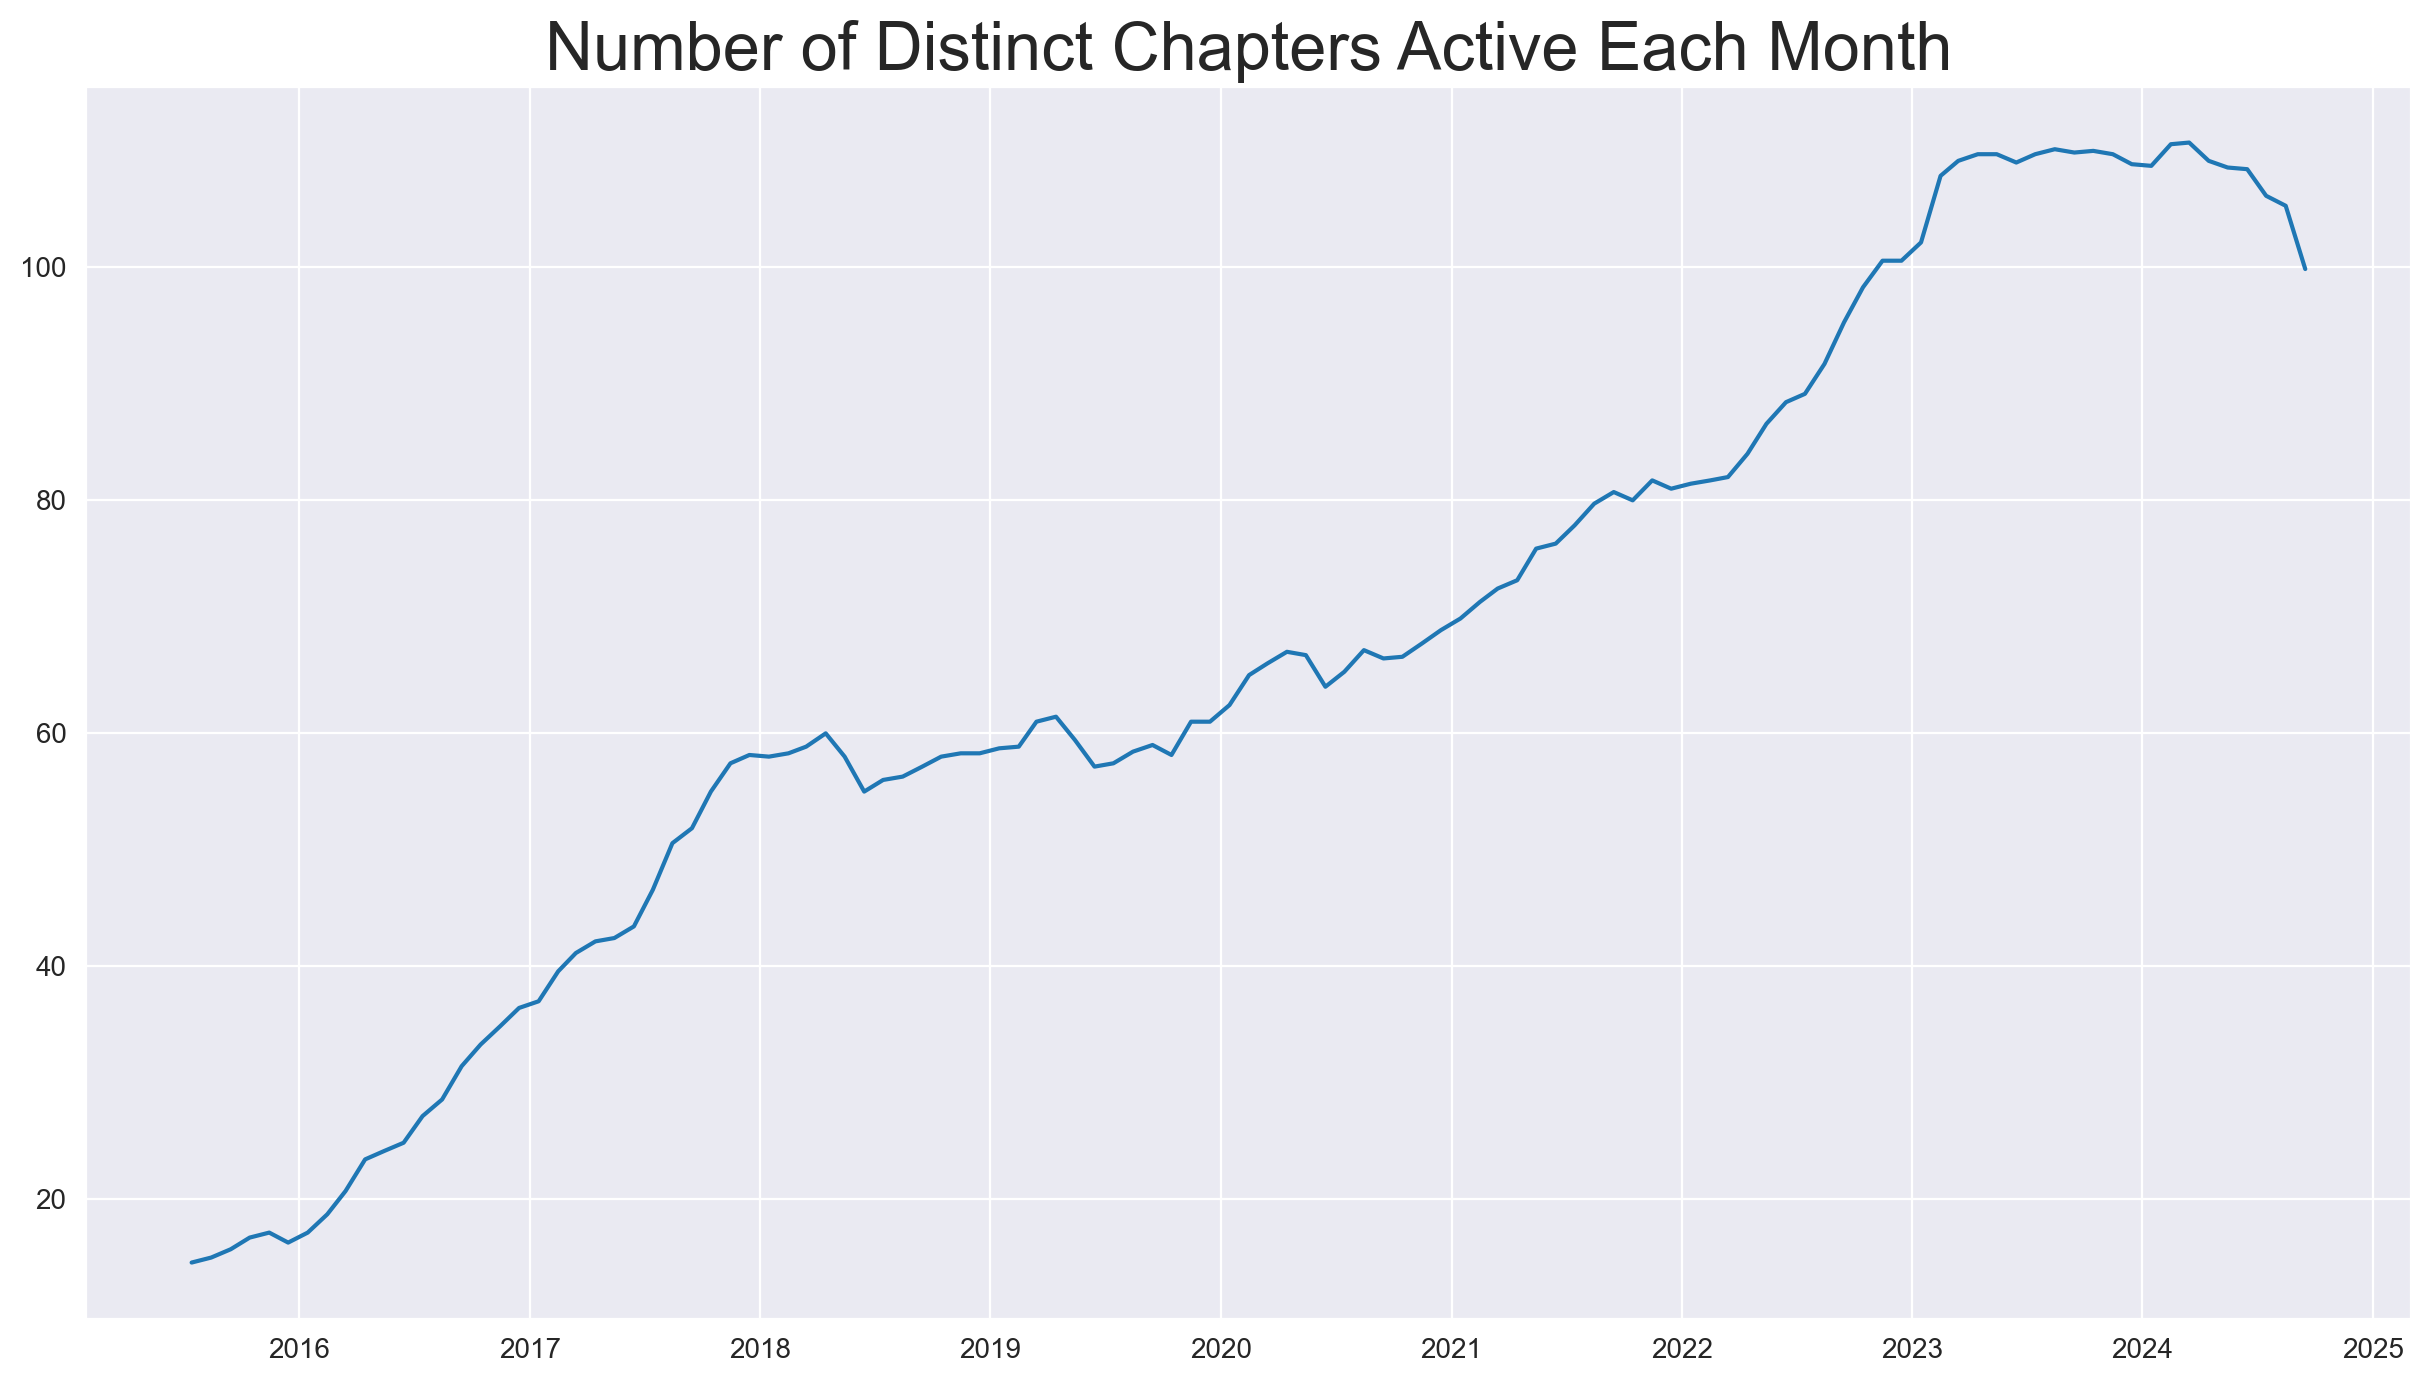

In [35]:
sns.set_style('darkgrid')
ax = df.groupby('month').aggregate({'chapter':'nunique'}).rolling(7).mean().plot(figsize=(15,8), legend=None)
ax.set_xlabel(None);
ax.set_title("Number of Distinct Chapters Active Each Month", fontsize=24)

Text(0.5, 1.0, 'Number of Distinct Mappers Active Each Month')

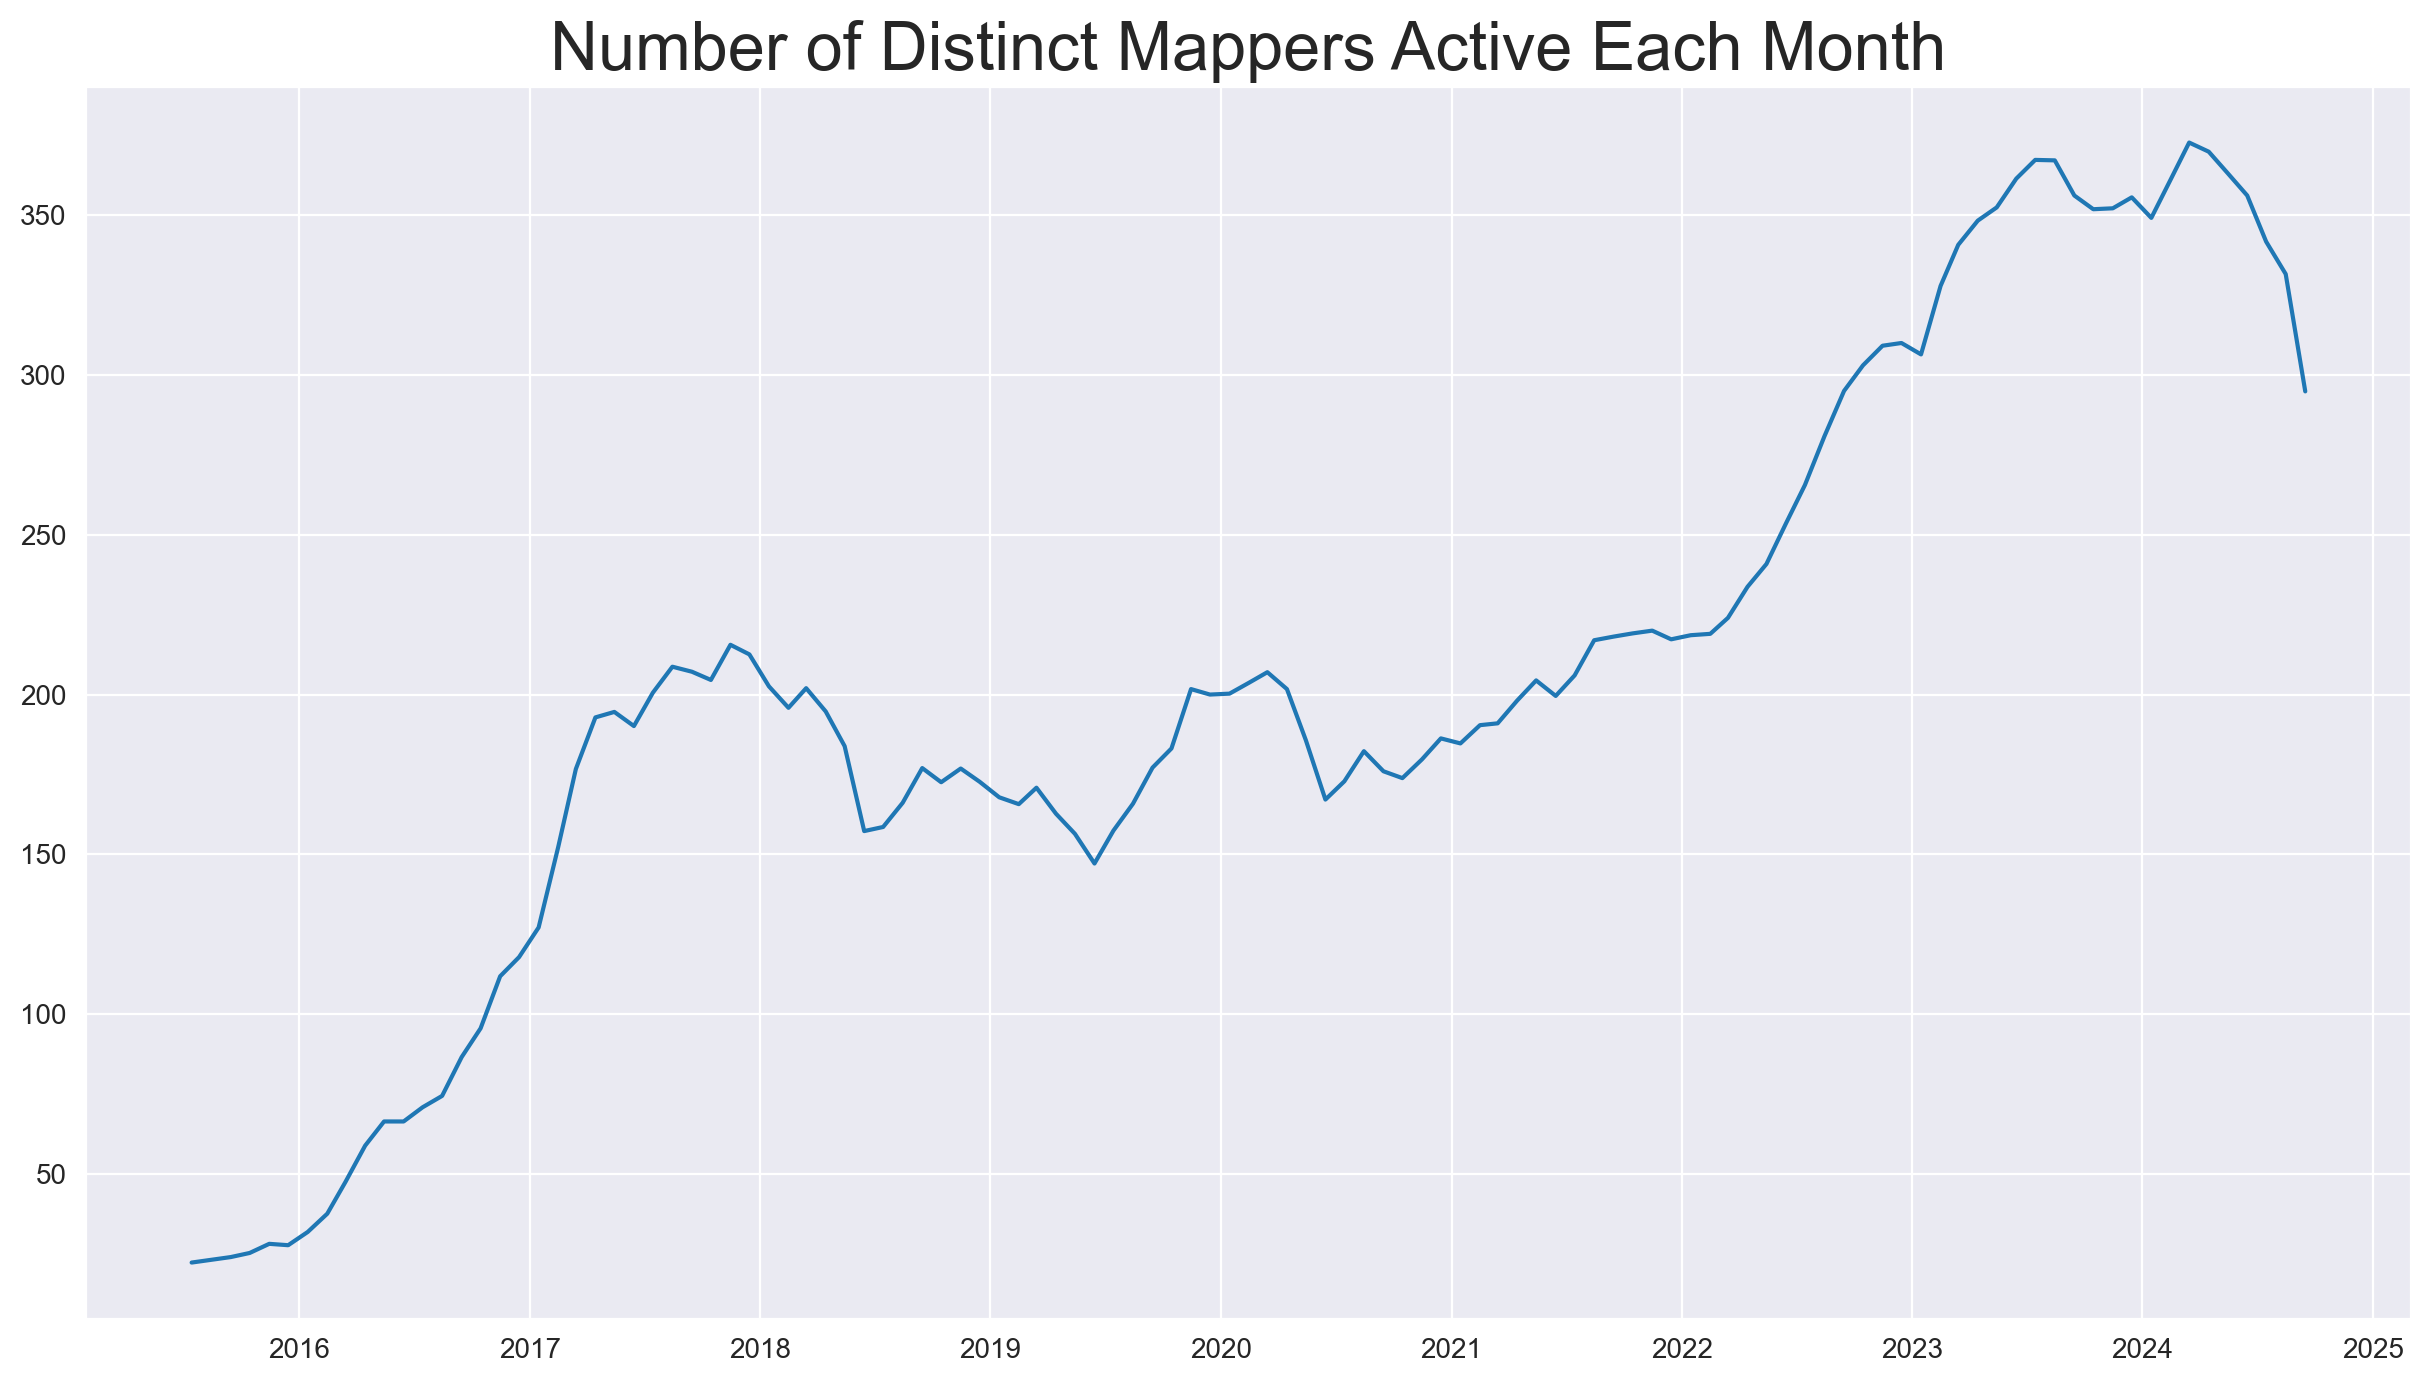

In [36]:
sns.set_style('darkgrid')
ax = df.groupby('month').aggregate({'uid':'nunique'}).rolling(7).mean().plot(figsize=(15,8), legend=None)
ax.set_xlabel(None);
ax.set_title("Number of Distinct Mappers Active Each Month", fontsize=24)

In [37]:
edits_per_country = df_[df_.month.apply(lambda d: d.year == 2023)].groupby('edit_A3').aggregate({
    'uid':'nunique',
    'chapter': 'nunique',
    'all_feats': 'sum'
}).rename(columns={'uid':'mappers','chapter':'chapters','all_feats':'features_edited'})

In [ ]:
edits_per_country['year'] = 2023

In [ ]:
edits_per_country.to_csv('ym_edits_per_country.csv')